# Airbnb Profitability Function

The purpose is to create a function to estimate if it is profitable for a existing or perspective homeowner to invest in a property to Airbnb. 

Effectively, the forumla will take this form:

        Profit = Airbnb Revenue - Mortgage Payments

Airbnb revenue and the cost of the mortgage will be calculated over a 12 month period, so profit will represent yearly profit.

Average mortgage rate for a 30-year mortgage for the state of Washington:  6.20% (as of Wednesday, September 14th, 2022)
[Source](https://www.bankrate.com/mortgages/mortgage-rates/washington/?mortgageType=Refinance&partnerId=Refinance&pid=br3&pointsChanged=false&refinanceCashOutAmount=0&refinanceLoanAmount=765600&refinanceLoanTerms=30yr%2C15yr&refinancePoints=All&refinancePropertyType=SingleFamily&refinancePropertyUse=PrimaryResidence&refinancePropertyValue=957000&searchChanged=false&showingStacked=all&ttcid&userCreditScore=740&userFha=false&userVeteranStatus=NoMilitaryService&zipCode=10270)

Average Airbnb Occupancy Rate for King County: 87.91% 
    [Source](https://www.dpgo.com/go/top-10-vacation-rental-locations/)

In [2]:
avg_mortgage_rate = 0.0620
avg_airbnb_occupancy = .8791

Load in Airbnb Average Price and House Price data based on Seattle zipcode

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from   sklearn.linear_model import LinearRegression
from   sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

In [4]:
df = pd.read_excel('/Users/weatherford/Documents/Flatiron/Phase_2_Housing_Project/data/king_county_home_sales.xlsx')

In [5]:
df

,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,sqft_lot15,renovated,view_ord,condition_ord,grade_ord,age,point,distance_to_starbucks_miles,distance_to_amazon_miles,distance_to_needle_miles
0,0,7129300520,2014-10-13,221900,3,1.00,1180,5650,1.0,0,...,5650,0,0,2,4,60,"(47.5112, -122.257)",6.041009,8.552873,8.697321
1,1,6414100192,2014-12-09,538000,3,2.25,2570,7242,2.0,0,...,7639,1,0,2,4,64,"(47.5112, -122.257)",6.041009,8.552873,8.697321
2,2,5631500400,2015-02-25,180000,2,1.00,770,10000,1.0,0,...,8062,0,0,2,3,82,"(47.721, -122.319)",9.717661,6.846950,7.085697
3,3,2487200875,2014-12-09,604000,4,3.00,1960,5000,1.0,0,...,5000,0,0,4,4,50,"(47.7379, -122.233)",11.858223,9.319655,9.758480
4,4,1954400510,2015-02-18,510000,3,2.00,1680,8080,1.0,0,...,7503,0,0,2,5,28,"(47.5208, -122.393)",4.945854,7.509964,7.184440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,21592,263000018,2014-05-21,360000,3,2.50,1530,1131,3.0,0,...,1509,0,0,2,5,6,"(47.5773, -122.409)",3.456165,4.604793,4.085285
21593,21593,6600060120,2015-02-23,400000,4,2.50,2310,5813,2.0,0,...,7200,0,0,2,5,1,"(47.6993, -122.346)",8.204234,5.315147,5.446183
21594,21594,1523300141,2014-06-23,402101,2,0.75,1020,1350,2.0,0,...,2007,0,0,2,4,6,"(47.5107, -122.362)",4.999896,7.821711,7.608764
21595,21595,291310100,2015-01-16,400000,3,2.50,1600,2388,2.0,0,...,1287,0,0,2,5,11,"(47.5944, -122.299)",1.938102,2.628624,2.962102


In [6]:
len(df['zipcode'].unique())

70

In [7]:
seattle_df = pd.read_csv('/Users/weatherford/Documents/Flatiron/Phase_2_Housing_Project/data/seattle.csv')
seattle_df = seattle_df.drop(columns= 'Unnamed: 0')
seattle_df

,id_x,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,sqft_above,sqft_basement,...,renov_yr_clean,view_ord,condition_ord,grade_ord,age,id_y,latitude,longitude,airbnb_avg_price,house_price
0,7129300520,2014-10-13,3,1.00,1180,5650,1.0,0,1180,0.0,...,1955.0,0.0,2.0,4.0,60,7.345680e+16,47.500403,-122.243751,170.121951,221900.0
1,4060000240,2014-06-23,2,1.00,880,6780,1.0,0,880,0.0,...,1945.0,0.0,3.0,3.0,70,7.345680e+16,47.500403,-122.243751,170.121951,205425.0
2,4058801670,2014-07-17,3,2.25,2100,8201,1.0,0,1620,480.0,...,1967.0,2.0,2.0,5.0,48,7.345680e+16,47.500403,-122.243751,170.121951,445000.0
3,2976800796,2014-09-25,3,1.00,1300,5898,1.0,0,1300,0.0,...,1961.0,0.0,2.0,4.0,54,7.345680e+16,47.500403,-122.243751,170.121951,236000.0
4,6874200960,2015-02-27,2,1.00,860,5265,1.0,0,860,0.0,...,1931.0,0.0,2.0,3.0,84,7.345680e+16,47.500403,-122.243751,170.121951,170000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9351,2895800590,2014-10-20,5,2.50,2170,2752,2.0,0,2170,0.0,...,2014.0,0.0,2.0,5.0,1,6.652046e+16,47.541882,-122.358118,176.106557,359800.0
9352,3438503021,2014-11-05,3,2.50,2430,7049,2.0,0,2430,0.0,...,2007.0,0.0,2.0,5.0,8,6.652046e+16,47.541882,-122.358118,176.106557,443000.0
9353,880000205,2014-07-29,3,2.00,1260,1125,2.0,0,810,450.0,...,2011.0,0.0,2.0,4.0,4,6.652046e+16,47.541882,-122.358118,176.106557,249000.0
9354,3438501329,2014-05-20,2,2.50,1590,2656,2.0,0,1220,370.0,...,2009.0,0.0,2.0,4.0,6,6.652046e+16,47.541882,-122.358118,176.106557,305000.0


In [8]:
len(seattle_df.zipcode.unique())

28

In [9]:
airbnb_revenue = seattle_df['airbnb_avg_price'] * (365) * avg_airbnb_occupancy
airbnb_revenue


0       54587.285671
1       54587.285671
2       54587.285671
3       54587.285671
4       54587.285671
            ...     
9351    56507.575225
9352    56507.575225
9353    56507.575225
9354    56507.575225
9355    56507.575225
Name: airbnb_avg_price, Length: 9356, dtype: float64

Mortgage Cost

$$Mortgage Cost = P  \frac{r (1+ r)^{n}}{ (1+r)^{n} - 1}$$

Where P equals housing price, r equals the interest rate, and n equals the number of payments over the duration of the loan


For our particular model:
- r = 6.20%
- n = 30, as we are calculating yearly mortgage cost for a 30 year mortgage
- P is each house's sale price from the Seattle subset of the King County dataset


In [10]:
seattle_df.columns

Index(['id_x', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'sqft_above', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'renov_yr_clean', 'view_ord', 'condition_ord', 'grade_ord', 'age',
       'id_y', 'latitude', 'longitude', 'airbnb_avg_price', 'house_price'],
      dtype='object')

In [11]:
len(seattle_df['zipcode'].unique())

28

In [12]:
360000 * (avg_mortgage_rate * (1+avg_mortgage_rate)**30)/(((1+0.062)**30-1)) #Test of the formula

26715.736475425732

In [13]:
annual_mortgage = seattle_df['house_price'] * (avg_mortgage_rate * (1+avg_mortgage_rate)**30)/((1+0.062)**30-1)
annual_mortgage

0       16467.283122
1       15244.667126
2       33023.618699
3       17513.649467
4       12615.764447
            ...     
9351    26700.894400
9352    32875.197941
9353    18478.384396
9354    22634.165625
9355    24489.425102
Name: house_price, Length: 9356, dtype: float64

In [14]:
profit = airbnb_revenue - annual_mortgage
profit
profit.describe()

count      9356.000000
mean      17392.315172
std       27759.683333
min     -504513.035961
25%        8488.380114
50%       20658.547071
75%       30380.719417
max      111661.866844
dtype: float64

In [15]:
seattle_df['profit'] = profit
seattle_df

,id_x,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,sqft_above,sqft_basement,...,view_ord,condition_ord,grade_ord,age,id_y,latitude,longitude,airbnb_avg_price,house_price,profit
0,7129300520,2014-10-13,3,1.00,1180,5650,1.0,0,1180,0.0,...,0.0,2.0,4.0,60,7.345680e+16,47.500403,-122.243751,170.121951,221900.0,38120.002549
1,4060000240,2014-06-23,2,1.00,880,6780,1.0,0,880,0.0,...,0.0,3.0,3.0,70,7.345680e+16,47.500403,-122.243751,170.121951,205425.0,39342.618544
2,4058801670,2014-07-17,3,2.25,2100,8201,1.0,0,1620,480.0,...,2.0,2.0,5.0,48,7.345680e+16,47.500403,-122.243751,170.121951,445000.0,21563.666972
3,2976800796,2014-09-25,3,1.00,1300,5898,1.0,0,1300,0.0,...,0.0,2.0,4.0,54,7.345680e+16,47.500403,-122.243751,170.121951,236000.0,37073.636204
4,6874200960,2015-02-27,2,1.00,860,5265,1.0,0,860,0.0,...,0.0,2.0,3.0,84,7.345680e+16,47.500403,-122.243751,170.121951,170000.0,41971.521224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9351,2895800590,2014-10-20,5,2.50,2170,2752,2.0,0,2170,0.0,...,0.0,2.0,5.0,1,6.652046e+16,47.541882,-122.358118,176.106557,359800.0,29806.680826
9352,3438503021,2014-11-05,3,2.50,2430,7049,2.0,0,2430,0.0,...,0.0,2.0,5.0,8,6.652046e+16,47.541882,-122.358118,176.106557,443000.0,23632.377285
9353,880000205,2014-07-29,3,2.00,1260,1125,2.0,0,810,450.0,...,0.0,2.0,4.0,4,6.652046e+16,47.541882,-122.358118,176.106557,249000.0,38029.190830
9354,3438501329,2014-05-20,2,2.50,1590,2656,2.0,0,1220,370.0,...,0.0,2.0,4.0,6,6.652046e+16,47.541882,-122.358118,176.106557,305000.0,33873.409600


In [16]:
seattle_df["profitable?"]= np.where(seattle_df['profit']>0, 1, 0)
seattle_df

,id_x,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,sqft_above,sqft_basement,...,condition_ord,grade_ord,age,id_y,latitude,longitude,airbnb_avg_price,house_price,profit,profitable?
0,7129300520,2014-10-13,3,1.00,1180,5650,1.0,0,1180,0.0,...,2.0,4.0,60,7.345680e+16,47.500403,-122.243751,170.121951,221900.0,38120.002549,1
1,4060000240,2014-06-23,2,1.00,880,6780,1.0,0,880,0.0,...,3.0,3.0,70,7.345680e+16,47.500403,-122.243751,170.121951,205425.0,39342.618544,1
2,4058801670,2014-07-17,3,2.25,2100,8201,1.0,0,1620,480.0,...,2.0,5.0,48,7.345680e+16,47.500403,-122.243751,170.121951,445000.0,21563.666972,1
3,2976800796,2014-09-25,3,1.00,1300,5898,1.0,0,1300,0.0,...,2.0,4.0,54,7.345680e+16,47.500403,-122.243751,170.121951,236000.0,37073.636204,1
4,6874200960,2015-02-27,2,1.00,860,5265,1.0,0,860,0.0,...,2.0,3.0,84,7.345680e+16,47.500403,-122.243751,170.121951,170000.0,41971.521224,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9351,2895800590,2014-10-20,5,2.50,2170,2752,2.0,0,2170,0.0,...,2.0,5.0,1,6.652046e+16,47.541882,-122.358118,176.106557,359800.0,29806.680826,1
9352,3438503021,2014-11-05,3,2.50,2430,7049,2.0,0,2430,0.0,...,2.0,5.0,8,6.652046e+16,47.541882,-122.358118,176.106557,443000.0,23632.377285,1
9353,880000205,2014-07-29,3,2.00,1260,1125,2.0,0,810,450.0,...,2.0,4.0,4,6.652046e+16,47.541882,-122.358118,176.106557,249000.0,38029.190830,1
9354,3438501329,2014-05-20,2,2.50,1590,2656,2.0,0,1220,370.0,...,2.0,4.0,6,6.652046e+16,47.541882,-122.358118,176.106557,305000.0,33873.409600,1


In [17]:
seattle_df.loc[seattle_df.profit < 0]

,id_x,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,sqft_above,sqft_basement,...,condition_ord,grade_ord,age,id_y,latitude,longitude,airbnb_avg_price,house_price,profit,profitable?
18,7567600045,2014-08-27,2,1.00,1150,12775,1.0,1,1150,0.0,...,3.0,3.0,107,7.345680e+16,47.500403,-122.243751,170.121951,825000.0,-6636.277085,0
21,8069000075,2014-12-29,4,1.75,2460,10061,1.0,1,1410,1050.0,...,2.0,4.0,54,7.345680e+16,47.500403,-122.243751,170.121951,790000.0,-4038.913817,0
24,8073000550,2015-04-15,4,3.75,3190,17186,2.0,1,3190,0.0,...,2.0,7.0,16,7.345680e+16,47.500403,-122.243751,170.121951,1700000.0,-71570.358797,0
68,623059016,2014-07-17,4,3.25,3190,11774,2.0,1,2610,580.0,...,2.0,5.0,59,7.345680e+16,47.500403,-122.243751,170.121951,1100000.0,-27044.131338,0
78,4058801702,2015-02-06,4,2.50,4940,10037,1.0,0,3450,1490.0,...,2.0,6.0,62,7.345680e+16,47.500403,-122.243751,170.121951,800000.0,-4781.017608,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9006,4022905473,2014-12-05,5,3.00,2560,12480,1.0,0,1590,970.0,...,2.0,5.0,3,9.860969e+16,47.739865,-122.301011,130.418605,565000.0,-81.250888,0
9013,4022900652,2014-11-18,5,3.25,2860,20790,1.0,0,1800,1060.0,...,3.0,4.0,50,9.860969e+16,47.739865,-122.301011,130.418605,565000.0,-81.250888,0
9017,4024100915,2014-12-31,4,2.75,3250,10000,2.0,0,3250,0.0,...,2.0,6.0,1,9.860969e+16,47.739865,-122.301011,130.418605,689000.0,-9283.337896,0
9018,4027700014,2015-02-25,3,3.50,2460,14155,2.0,0,1900,560.0,...,2.0,5.0,1,9.860969e+16,47.739865,-122.301011,130.418605,665000.0,-7502.288798,0


## EDA for profit to see what the primary drivers are

Hypothesis: probably largely linked to the drivers of price

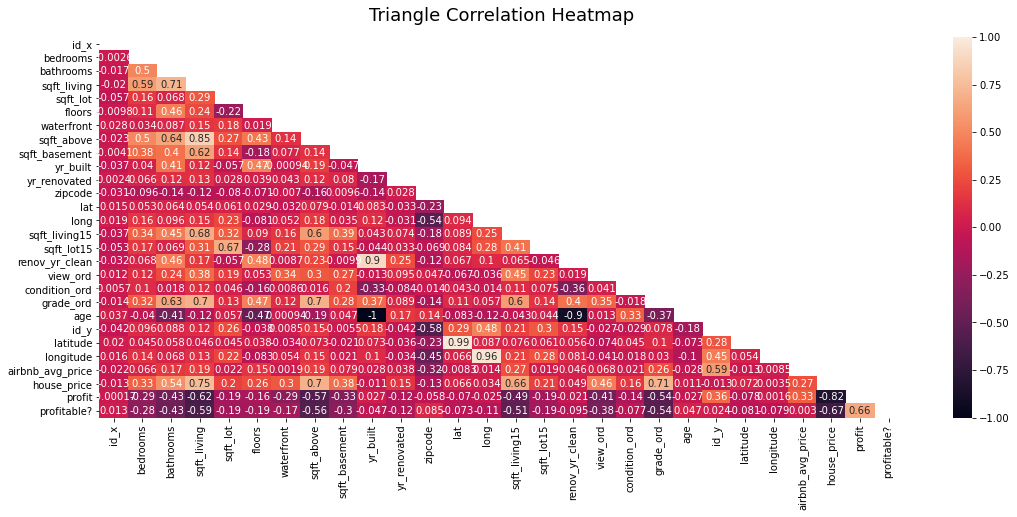

In [18]:
plt.figure(figsize=(18,7))
mask = np.triu(np.ones_like(seattle_df.corr(), dtype=bool))
heatmap = sns.heatmap(seattle_df.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16)
plt.show();

<AxesSubplot:>

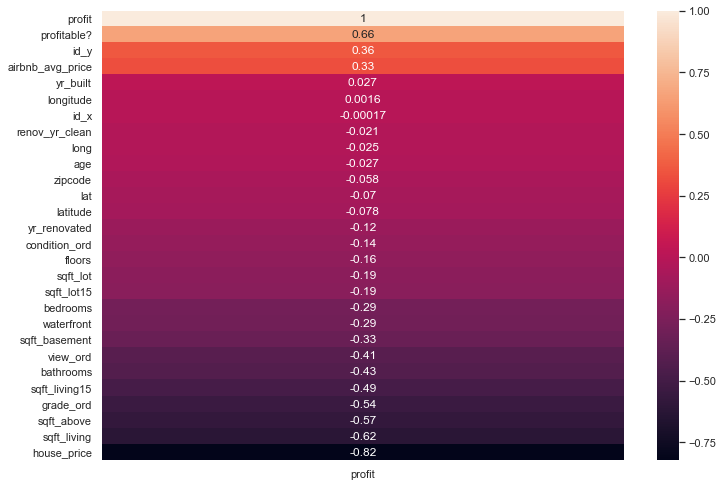

In [19]:
corr = seattle_df.corr()[['profit']].sort_values(by='profit', ascending=False)

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(corr, annot=True)

<AxesSubplot:xlabel='sqft_living', ylabel='profit'>

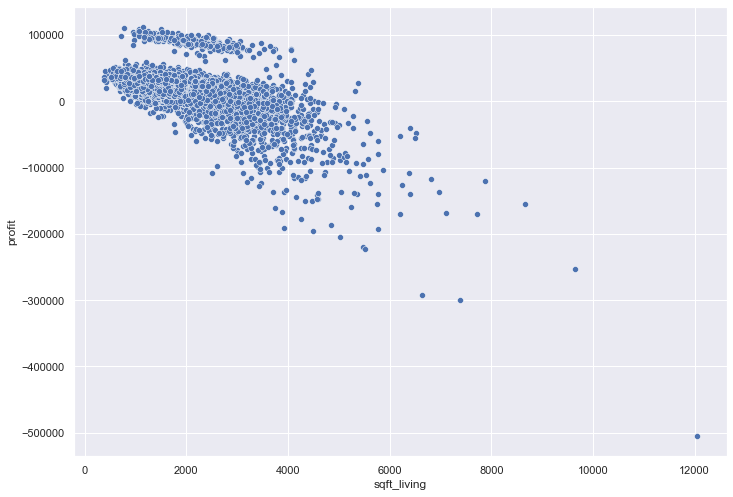

In [20]:
#g = sns.FacetGrid(seattle_df, hue="waterfront", col="view_ord")

#g.map(
    
sns.scatterplot(data= seattle_df, x="sqft_living", y="profit")

In [21]:
X, y = seattle_df[['sqft_living']] , seattle_df[['profit']]

# Generate train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.3, random_state=42
)

# Init, fit, score
multi_model = LinearRegression()
multi_model.fit(X_train, y_train)

print(f"Training score: {multi_model.score(X_train, y_train)}")
multi_model_score = multi_model.score(X_test, y_test)
print(f"Test score: {multi_model.score(X_test, y_test)}")

Training score: 0.3706621070508077
Test score: 0.4256131804110219


In [22]:
df1 = pd.read_excel('/Users/weatherford/Documents/Flatiron/Phase_2_Housing_Project/data/washington_state_income_by_zipcode.xlsx')

In [23]:
df1['zipcode'] = df1['Zip Code']
df1 = df1.drop(columns=['Zip Code'])
df1

,#,Location,City,Population,Avg. Income/H/hold,National Rank,zipcode
0,1,"47.626035, -122.233707","Medina, Washington",3050,132665,#46,98039
1,2,"47.655058, -122.025817","Redmond, Washington",31203,96028,#335,98053
2,3,"47.855439, -122.595728","Port Gamble, Washington",102,94366,#364,98364
3,4,"47.562356, -122.226514","Mercer Island, Washington",22036,91904,#415,98040
4,5,"47.578444, -122.013924","Issaquah, Washington",28427,91146,#430,98029
...,...,...,...,...,...,...,...
562,558,"47.251349, -122.443181","Tacoma, Washington",4935,15847,"#31,304",98402
563,559,"46.510216, -118.194986","Starbuck, Washington",72,13393,"#31,550",99359
564,560,"47.604569, -122.335359","Seattle, Washington",180,0,"#31,889",98174
565,561,"47.606211, -122.333792","Seattle, Washington",1,0,"#31,893",98154


Made dataframe including profitability data and household income data, merged on zipcode, for Seattle metro area

In [24]:
df = pd.merge(seattle_df, df1, on='zipcode', how='inner')

In [ ]:
df.loc[df.bedrooms == 33]
df = df.drop(labels=3099, axis=0)

In [28]:
df.columns

Index(['id_x', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'sqft_above', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'renov_yr_clean', 'view_ord', 'condition_ord', 'grade_ord', 'age',
       'id_y', 'latitude', 'longitude', 'airbnb_avg_price', 'house_price',
       'profit', 'profitable?', '#', 'Location', 'City', 'Population',
       'Avg. Income/H/hold', 'National Rank'],
      dtype='object')

In [42]:
df['Avg. Income/H/hold']

0       47461
1       47461
2       47461
3       47461
4       47461
        ...  
9351    40815
9352    40815
9353    40815
9354    40815
9355    40815
Name: Avg. Income/H/hold, Length: 9356, dtype: object

In [47]:
top_cities = df.groupby(by=['Avg. Income/H/hold']).mean()
top_cities = top_cities.sort_values(by=['profit'], ascending=False)
top_cities

,id_x,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,sqft_above,sqft_basement,yr_built,...,condition_ord,grade_ord,age,id_y,latitude,longitude,airbnb_avg_price,house_price,profit,profitable?
Avg. Income/H/hold,,,,,,,,,,,,,,,,,,,,,
61813,4.415451e+09,3.480565,2.143110,2122.724382,11935.374558,1.420495,0.003534,1781.098940,324.911661,1977.830389,...,2.300353,4.611307,37.169611,5.829030e+17,47.740110,-122.265170,385.000000,4.624889e+05,89214.053184,1.000000
40815,4.412164e+09,3.101493,1.804478,1487.883582,5554.238806,1.382090,0.000000,1188.271642,295.223881,1965.537313,...,2.247761,3.865672,49.462687,6.652046e+16,47.541882,-122.358118,176.106557,3.195814e+05,32791.318822,0.997015
41097,3.204785e+09,2.996283,1.433086,1468.624535,11269.843866,1.159851,0.000000,1234.089219,229.182156,1952.721190,...,2.245353,3.509294,62.278810,1.733117e+17,47.500964,-122.310838,155.425926,2.403284e+05,32036.890415,1.000000
47461,4.291467e+09,3.305344,1.731870,1729.351145,8309.122137,1.185115,0.034351,1325.992366,396.068702,1955.232824,...,2.320611,3.816794,59.767176,7.345680e+16,47.500403,-122.243751,170.121951,3.106128e+05,31536.595316,0.969466
42195,3.289489e+09,2.996241,2.045113,1579.548872,3194.368421,1.834586,0.000000,1317.218045,256.691729,1959.631579,...,2.421053,4.424812,55.368421,1.198376e+17,47.667910,-122.374809,211.581498,5.791098e+05,24914.514159,0.969925
44697,4.283876e+09,3.132150,1.765286,1689.303748,5780.185404,1.343195,0.005917,1331.015779,354.737673,1950.305720,...,2.351085,3.976331,64.694280,7.598362e+16,47.543534,-122.277837,171.003484,4.180194e+05,23848.769273,0.944773
38413,4.952066e+09,3.204301,1.931452,1704.623656,5204.844086,1.376344,0.000000,1300.268817,402.795699,1957.908602,...,2.403226,4.016129,57.091398,1.386757e+17,47.549144,-122.307968,155.711538,3.556785e+05,23568.357394,1.000000
54563,5.207714e+09,3.066667,1.987121,1853.369697,4979.421212,1.528788,0.003030,1419.642424,419.000000,1953.675758,...,2.512121,4.569697,61.324242,7.703663e+16,47.574526,-122.398955,216.022857,6.186951e+05,23401.979614,0.903030
47519,5.268250e+09,2.836158,1.678672,1543.596045,5114.610169,1.350282,0.000000,1249.019774,285.762712,1952.725989,...,2.466102,4.031073,62.274011,3.922233e+16,47.556849,-122.375475,169.449438,4.247346e+05,22851.779392,0.935028


In [61]:
top_zipcodes = df.groupby(by=['zipcode']).mean()
top_zipcodes = top_zipcodes.sort_values(by=['profit'], ascending=False)
top_zipcodes = top_zipcodes.reset_index()
top_zipcodes

,zipcode,id_x,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,sqft_above,sqft_basement,...,condition_ord,grade_ord,age,id_y,latitude,longitude,airbnb_avg_price,house_price,profit,profitable?
0,98028,4.415451e+09,3.480565,2.143110,2122.724382,11935.374558,1.420495,0.003534,1781.098940,324.911661,...,2.300353,4.611307,37.169611,5.829030e+17,47.740110,-122.265170,385.000000,4.624889e+05,89214.053184,1.000000
1,98106,4.412164e+09,3.101493,1.804478,1487.883582,5554.238806,1.382090,0.000000,1188.271642,295.223881,...,2.247761,3.865672,49.462687,6.652046e+16,47.541882,-122.358118,176.106557,3.195814e+05,32791.318822,0.997015
2,98168,3.204785e+09,2.996283,1.433086,1468.624535,11269.843866,1.159851,0.000000,1234.089219,229.182156,...,2.245353,3.509294,62.278810,1.733117e+17,47.500964,-122.310838,155.425926,2.403284e+05,32036.890415,1.000000
3,98178,4.291467e+09,3.305344,1.731870,1729.351145,8309.122137,1.185115,0.034351,1325.992366,396.068702,...,2.320611,3.816794,59.767176,7.345680e+16,47.500403,-122.243751,170.121951,3.106128e+05,31536.595316,0.969466
4,98107,3.289489e+09,2.996241,2.045113,1579.548872,3194.368421,1.834586,0.000000,1317.218045,256.691729,...,2.421053,4.424812,55.368421,1.198376e+17,47.667910,-122.374809,211.581498,5.791098e+05,24914.514159,0.969925
5,98118,4.283876e+09,3.132150,1.765286,1689.303748,5780.185404,1.343195,0.005917,1331.015779,354.737673,...,2.351085,3.976331,64.694280,7.598362e+16,47.543534,-122.277837,171.003484,4.180194e+05,23848.769273,0.944773
6,98108,4.952066e+09,3.204301,1.931452,1704.623656,5204.844086,1.376344,0.000000,1300.268817,402.795699,...,2.403226,4.016129,57.091398,1.386757e+17,47.549144,-122.307968,155.711538,3.556785e+05,23568.357394,1.000000
7,98116,5.207714e+09,3.066667,1.987121,1853.369697,4979.421212,1.528788,0.003030,1419.642424,419.000000,...,2.512121,4.569697,61.324242,7.703663e+16,47.574526,-122.398955,216.022857,6.186951e+05,23401.979614,0.903030
8,98126,5.268250e+09,2.836158,1.678672,1543.596045,5114.610169,1.350282,0.000000,1249.019774,285.762712,...,2.466102,4.031073,62.274011,3.922233e+16,47.556849,-122.375475,169.449438,4.247346e+05,22851.779392,0.935028
9,98119,4.303215e+09,3.260870,2.224185,2005.614130,3615.217391,1.793478,0.000000,1589.961957,390.978261,...,2.375000,5.021739,67.380435,6.924101e+16,47.637914,-122.367207,260.294643,8.497148e+05,20463.474336,0.831522


In [120]:
sns.set_palette(sns.color_palette("hls"))

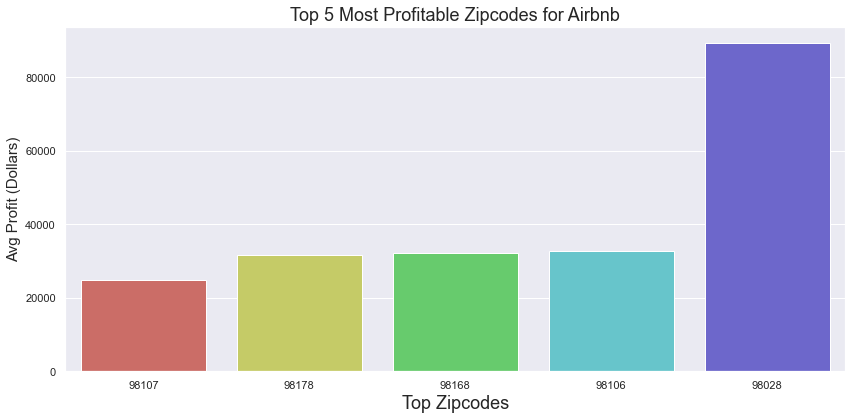

In [151]:
plt.figure(figsize=(12,6))
# make barplot and sort bars
sns.barplot(data=top_zipcodes.head(5), x="zipcode", y="profit", order=top_zipcodes.head().sort_values('profit').zipcode)   

#set labels
plt.xlabel("Top Zipcodes", size=18)
plt.ylabel("Avg Profit (Dollars)", size=15)
plt.title("Top 5 Most Profitable Zipcodes for Airbnb", size=18)
plt.tight_layout()
#plt.savefig(".png", dpi=100);



In [27]:
#df.to_csv('seattle_income_&_profit.csv')

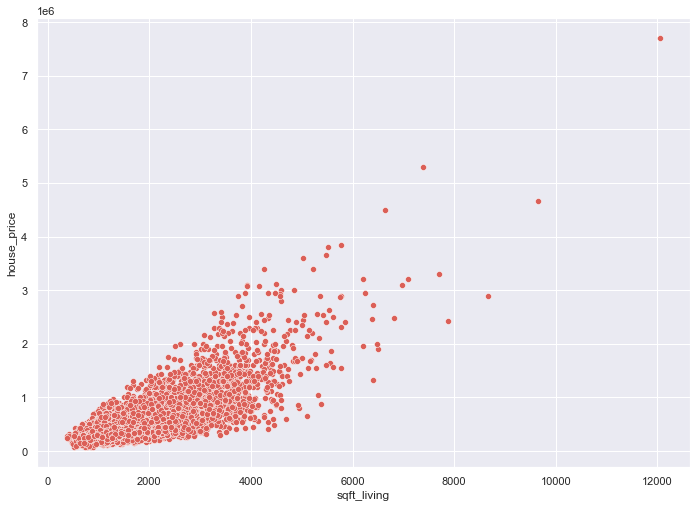

In [135]:
sns.scatterplot(data= df, x="sqft_living" , y="house_price");

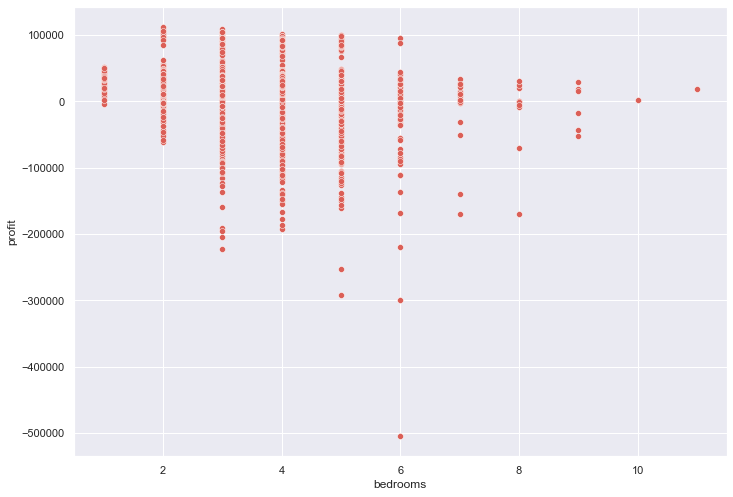

In [152]:
sns.scatterplot(data= df, x="bedrooms" , y="profit");

In [133]:
df.corr()

,id_x,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,sqft_above,sqft_basement,yr_built,...,condition_ord,grade_ord,age,id_y,latitude,longitude,airbnb_avg_price,house_price,profit,profitable?
id_x,1.000000,-0.002600,-0.016746,-0.019791,-0.057074,-0.009814,0.028325,-0.022893,-0.004128,-0.036705,...,0.005695,-0.014497,0.036705,-0.041868,0.019561,0.016270,-0.022200,-0.013177,-0.000167,0.012560
bedrooms,-0.002600,1.000000,0.498095,0.594166,0.164451,0.111948,0.033824,0.500846,0.379410,0.040483,...,0.102266,0.321130,-0.040483,0.096186,0.044537,0.140357,0.066303,0.331185,-0.285715,-0.280949
bathrooms,-0.016746,0.498095,1.000000,0.713849,0.068135,0.463446,0.086986,0.637718,0.402878,0.413886,...,0.017903,0.633019,-0.413886,0.088251,0.057639,0.068044,0.167427,0.535845,-0.426810,-0.430221
sqft_living,-0.019791,0.594166,0.713849,1.000000,0.289683,0.240187,0.149267,0.852736,0.624427,0.122555,...,0.119966,0.695338,-0.122555,0.117128,0.046331,0.127002,0.192034,0.749595,-0.621935,-0.593847
sqft_lot,-0.057074,0.164451,0.068135,0.289683,1.000000,-0.223591,0.177137,0.270382,0.143597,-0.057304,...,0.045679,0.130333,0.057304,0.255015,0.045443,0.224445,0.021896,0.203175,-0.186352,-0.189516
floors,-0.009814,0.111948,0.463446,0.240187,-0.223591,1.000000,0.018924,0.433072,-0.181457,0.469213,...,-0.160900,0.466529,-0.469213,-0.038201,0.037943,-0.082742,0.148941,0.257486,-0.164712,-0.194031
waterfront,0.028325,0.033824,0.086986,0.149267,0.177137,0.018924,1.000000,0.138565,0.076576,-0.000945,...,0.008614,0.118013,0.000945,0.008530,-0.034075,0.053658,0.001891,0.299409,-0.292527,-0.173640
sqft_above,-0.022893,0.500846,0.637718,0.852736,0.270382,0.433072,0.138565,1.000000,0.136408,0.190227,...,0.016193,0.700918,-0.190227,0.152158,0.073051,0.149465,0.189225,0.699716,-0.574673,-0.561656
sqft_basement,-0.004128,0.379410,0.402878,0.624427,0.143597,-0.181457,0.076576,0.136408,1.000000,-0.046713,...,0.198683,0.278342,0.046713,-0.005532,-0.020645,0.021456,0.078798,0.383032,-0.329195,-0.295404
yr_built,-0.036705,0.040483,0.413886,0.122555,-0.057304,0.469213,-0.000945,0.190227,-0.046713,1.000000,...,-0.327523,0.368124,-1.000000,0.175163,0.072611,0.101906,0.028107,-0.010801,0.027165,-0.047054


In [149]:
df

,id_x,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,sqft_above,sqft_basement,...,airbnb_avg_price,house_price,profit,profitable?,#,Location,City,Population,Avg. Income/H/hold,National Rank
0,7129300520,2014-10-13,3,1.00,1180,5650,1.0,0,1180,0.0,...,170.121951,221900.0,38120.002549,1,154,"47.496558, -122.251473","Seattle, Washington",21860,47461,"#6,983"
1,4060000240,2014-06-23,2,1.00,880,6780,1.0,0,880,0.0,...,170.121951,205425.0,39342.618544,1,154,"47.496558, -122.251473","Seattle, Washington",21860,47461,"#6,983"
2,4058801670,2014-07-17,3,2.25,2100,8201,1.0,0,1620,480.0,...,170.121951,445000.0,21563.666972,1,154,"47.496558, -122.251473","Seattle, Washington",21860,47461,"#6,983"
3,2976800796,2014-09-25,3,1.00,1300,5898,1.0,0,1300,0.0,...,170.121951,236000.0,37073.636204,1,154,"47.496558, -122.251473","Seattle, Washington",21860,47461,"#6,983"
4,6874200960,2015-02-27,2,1.00,860,5265,1.0,0,860,0.0,...,170.121951,170000.0,41971.521224,1,154,"47.496558, -122.251473","Seattle, Washington",21860,47461,"#6,983"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9351,2895800590,2014-10-20,5,2.50,2170,2752,2.0,0,2170,0.0,...,176.106557,359800.0,29806.680826,1,251,"47.546745, -122.349900","Seattle, Washington",23317,40815,"#11,333"
9352,3438503021,2014-11-05,3,2.50,2430,7049,2.0,0,2430,0.0,...,176.106557,443000.0,23632.377285,1,251,"47.546745, -122.349900","Seattle, Washington",23317,40815,"#11,333"
9353,880000205,2014-07-29,3,2.00,1260,1125,2.0,0,810,450.0,...,176.106557,249000.0,38029.190830,1,251,"47.546745, -122.349900","Seattle, Washington",23317,40815,"#11,333"
9354,3438501329,2014-05-20,2,2.50,1590,2656,2.0,0,1220,370.0,...,176.106557,305000.0,33873.409600,1,251,"47.546745, -122.349900","Seattle, Washington",23317,40815,"#11,333"


In [54]:
sns.scatterplot(data=tips, x="total_bill", y="tip")

Index(['id_x', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'sqft_above', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'renov_yr_clean', 'view_ord', 'condition_ord', 'grade_ord', 'age',
       'id_y', 'latitude', 'longitude', 'airbnb_avg_price', 'house_price',
       'profit', 'profitable?', '#', 'Location', 'City', 'Population',
       'Avg. Income/H/hold', 'National Rank'],
      dtype='object')